In [6]:
%pylab inline
import numpy as np
import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams
import cPickle as pickle

#%pylab inline
import lasagne
import os
import time

#import numpy as np
#import theano
#import theano.tensor as T

#import lasagne
#print(theano.generated_version.version)

Populating the interactive namespace from numpy and matplotlib


# LASAGNE

In [7]:
# ################## Download and prepare the MNIST dataset ##################
# This is just some way of getting the MNIST dataset from an online location
# and loading it into numpy arrays. It doesn't involve Lasagne at all.
def load_dataset_medical():
    def load_medical_images(filename):
        with open(filename, 'rb') as f22:
            data = pickle.load(f22)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_medical_labels(filename):
        with open(filename, 'rb') as f22:
            data = pickle.load(f22)
            data = [int(row)  for row in data]
        return np.asarray(data,dtype=int32)
    
    # We can now download and read the training and test set images and labels.
    X_train = load_medical_images('dataX.pkl')
    y_train = load_medical_labels('dataY.pkl')
    X_test =  load_medical_images('dataX.pkl')
    y_test = load_medical_labels('dataY.pkl')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-140], X_train[-140:]
    y_train, y_val = y_train[:-140], y_train[-140:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test    

def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
def build_cnn100(input_var=None):
    # As a third model, we'll create a CNN of two convolution + pooling stages
    # and a fully-connected hidden layer in front of the output layer.

    # Input layer, as usual:
    network = lasagne.layers.InputLayer(shape=(None, 1, 200, 200),
                                        input_var=input_var)
    # This time we do not apply input dropout, as it tends to work less well
    # for convolutional layers.

    # Convolutional layer with 32 kernels of size 5x5. Strided and padded
    # convolutions are supported as well; see the docstring.
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
    # Expert note: Lasagne provides alternative convolutional layers that
    # override Theano's choice of which implementation to use; for details
    # please see http://lasagne.readthedocs.org/en/latest/user/tutorial.html.

    # Max-pooling layer of factor 2 in both dimensions:
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    # Another convolution with 32 5x5 kernels, and another 2x2 pooling:
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify)
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    # A fully-connected layer of 256 units with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=256,
            nonlinearity=lasagne.nonlinearities.rectify)

    # And, finally, the 10-unit output layer with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=51,
            nonlinearity=lasagne.nonlinearities.softmax)

    return network

In [9]:
# ############################# Batch iterator ###############################
# This is just a simple helper function iterating over training data in
# mini-batches of a particular size, optionally in random order. It assumes
# data is available as numpy arrays. For big datasets, you could load numpy
# arrays as memory-mapped files (np.load(..., mmap_mode='r')), or write your
# own custom data iteration function. For small datasets, you can also copy
# them to GPU at once for slightly improved performance. This would involve
# several changes in the main program, though, and is not demonstrated here.

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [10]:
print("Loading data...")
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset_medical()
input_var = T.tensor4('inputs')
target_var = T.ivector('targets')
#mlp
#network = build_mlp(input_var)
network = build_cnn100(input_var)
print("cnn builded")


#custom_mlp
#depth, width, drop_in, drop_hid = model.split(':', 1)[1].split(',')
#network = build_custom_mlp(input_var, int(depth), int(width),float(drop_in), float(drop_hid))

#cnn
#network = build_cnn(input_var)

# Create a loss expression for training, i.e., a scalar objective we want
# to minimize (for our multi-class problem, it is the cross-entropy loss):
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()

# Create update expressions for training, i.e., how to modify the
# parameters at each training step. Here, we'll use Stochastic Gradient
# Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=0.01, momentum=0.9)


# Create a loss expression for validation/testing. The crucial difference
# here is that we do a deterministic forward pass through the network,
# disabling dropout layers.
test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                            target_var)
test_loss = test_loss.mean()
print("loss compiled ")
# As a bonus, also create an expression for the classification accuracy:
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                      dtype=theano.config.floatX)


# Compile a function performing a training step on a mini-batch (by giving
# the updates dictionary) and returning the corresponding training loss:
train_fn = theano.function([input_var, target_var], loss, updates=updates,allow_input_downcast=True)
print("train_fn compiled ")

# Compile a second function computing the validation loss and accuracy:
val_fn = theano.function([input_var, target_var], [test_loss, test_acc],allow_input_downcast=True)
print("validation fn compiled ")

print("compiled all functions ")

# Finally, launch the training loop.


Loading data...
cnn builded
loss compiled 
train_fn compiled 
validation fn compiled 
compiled all functions 


(949, 1, 200, 200)
(949,)
(200, 200)
(1089, 1, 200, 200)
(1089,)
28
(949,)


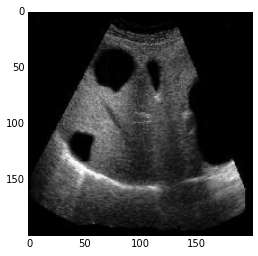

In [11]:
import pickle
print(X_train.shape)
print(y_train.shape)
print (X_train[0][0]).shape

X2=[]
with open('dataX.pkl', 'rb') as f:
     data_newX = pickle.load(f)
with open('dataY.pkl', 'rb') as f:
     data_newY = pickle.load(f)
#data_newY2 = [map(int, '99') for x in data_newY]  
data_newY2 = [int(row)  for row in data_newY]
print np.array(data_newX).shape       
print np.array(data_newY).shape       
print np.array(data_newY2[205])       
print(y_train.shape)
imshow(np.array(data_newX)[205][0],cmap=cm.Greys_r)


In [12]:
print("Starting training...")
num_epochs=25
try:     
    # We iterate over epochs:
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        print ("epoch is %s" % epoch)
        for batch in iterate_minibatches(X_train, y_train, 40, shuffle=True):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)
            train_batches += 1

        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, 40, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc / val_batches * 100))

   
    # Optionally, you could now dump the network weights to a file like this:
    # np.savez('model.npz', *lasagne.layers.get_all_param_values(network))
    #
    # And load them again later on like this:
    # with np.load('model.npz') as f:
    #     param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    # lasagne.layers.set_all_param_values(network, param_values)
except KeyboardInterrupt:
    print("The train was interrupted in %d" % epoch)

Starting training...
epoch is 0
Epoch 1 of 25 took 114.244s
  training loss:		3.292148
  validation loss:		2.663388
  validation accuracy:		22.50 %
epoch is 1
Epoch 2 of 25 took 109.674s
  training loss:		1.985209
  validation loss:		0.857703
  validation accuracy:		76.67 %
epoch is 2
Epoch 3 of 25 took 113.138s
  training loss:		0.732364
  validation loss:		0.439626
  validation accuracy:		90.00 %
epoch is 3
Epoch 4 of 25 took 111.158s
  training loss:		0.592054
  validation loss:		0.177721
  validation accuracy:		95.83 %
epoch is 4
Epoch 5 of 25 took 113.965s
  training loss:		0.377897
  validation loss:		0.140411
  validation accuracy:		96.67 %
epoch is 5
Epoch 6 of 25 took 109.762s
  training loss:		0.221469
  validation loss:		0.096384
  validation accuracy:		96.67 %
epoch is 6
Epoch 7 of 25 took 112.796s
  training loss:		0.173379
  validation loss:		0.057779
  validation accuracy:		97.50 %
epoch is 7
Epoch 8 of 25 took 111.082s
  training loss:		0.115479
  validation loss:		0.11

In [14]:
 # After training, we compute and print the test error:
print("After training, we compute and print the test error")
try:
    test_err = 0
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, 20, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        test_err += err
        test_acc += acc
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    print("  test accuracy:\t\t{:.2f} %".format(
        test_acc / test_batches * 100))
except KeyboardInterrupt:
    print("The train was interrupted in %d" % epoch)
#save model
savez('modelcnn_med1089.npz',*lasagne.layers.get_all_param_values(network))

After training, we compute and print the test error
Final results:
  test loss:			0.011152
  test accuracy:		99.63 %


[33]
Predicted 25 True 17


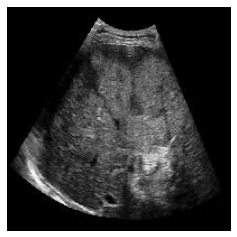

In [22]:
#getting prediction
def plot_mnist_sample(sample):
    imshow(sample[0],cmap=cm.Greys_r)
    xticks([])
    yticks([])

    
    
predictions=T.argmax(test_prediction,axis=1)
predict =theano.function (inputs=[input_var],
                         outputs=predictions,allow_input_downcast=True)

inputs, targets=iterate_minibatches(X_val, y_val,50, shuffle=True).next()
preds=predict(inputs)
bad_samples = where(preds!=targets)[0]
if len(bad_samples)>0:
    print (bad_samples)
    error=random.choice(bad_samples)
    plot_mnist_sample(X_val[error])
    print("Predicted %d True %d" % (preds [error],targets[error]))
else:
    print ("No error predict found")


In [ ]:
def plot_mnist_sample2(sample):
    #print sample[0]
    imshow(sample[0],cmap=cm.Greys_r)
    xticks([])
    yticks([])

inputs, targets=iterate_minibatches(X_val, y_val, 500, shuffle=False).next()
preds=predict(inputs)

good_samples = where(preds==targets)[0]
#print (good_samples)
good_work=random.choice(good_samples)
plot_mnist_sample2(X_val[good_work])
print("Predicted %d True %d" % (preds [good_work],targets[good_work]))


#  Deep Belif

In [ ]:
import gzip
import six.moves.cPickle as pickle
def load_data2(dataset):
    ''' Loads the dataset

    :type dataset: string
    :param dataset: the path to the dataset (here MNIST)
    '''

    #############
    # LOAD DATA #
    #############

    # Download the MNIST dataset if it is not present
    data_dir, data_file = os.path.split(dataset)
    if data_dir == "" and not os.path.isfile(dataset):
        # Check if dataset is in the data directory.
        new_path = os.path.join(
            os.path.split(__file__)[0],
            "..",
            "data",
            dataset
        )
        
        if os.path.isfile(new_path) or data_file == 'mnist.pkl.gz':
            dataset = new_path

    if (not os.path.isfile(dataset)) and data_file == 'mnist.pkl.gz':
        from six.moves import urllib
        origin = (
            'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        )
        print('Downloading data from %s' % origin)
        urllib.request.urlretrieve(origin, dataset)

    print('... loading data')

    # Load the dataset
    with gzip.open(dataset, 'rb') as f:
        try:
            train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
        except:
            train_set, valid_set, test_set = pickle.load(f)
    # train_set, valid_set, test_set format: tuple(input, target)
    # input is a numpy.ndarray of 2 dimensions (a matrix)
    # where each row corresponds to an example. target is a
    # numpy.ndarray of 1 dimension (vector) that has the same length as
    # the number of rows in the input. It should give the target
    # to the example with the same index in the input.

    def shared_dataset(data_xy, borrow=True):
        """ Function that loads the dataset into shared variables

        The reason we store our dataset in shared variables is to allow
        Theano to copy it into the GPU memory (when code is run on GPU).
        Since copying data into the GPU is slow, copying a minibatch everytime
        is needed (the default behaviour if the data is not in a shared
        variable) would lead to a large decrease in performance.
        """
        data_x, data_y = data_xy
        shared_x = theano.shared(numpy.asarray(data_x,
                                               dtype=theano.config.floatX),
                                 borrow=borrow)
        shared_y = theano.shared(numpy.asarray(data_y,
                                               dtype=theano.config.floatX),
                                 borrow=borrow)
        # When storing data on the GPU it has to be stored as floats
        # therefore we will store the labels as ``floatX`` as well
        # (``shared_y`` does exactly that). But during our computations
        # we need them as ints (we use labels as index, and if they are
        # floats it doesn't make sense) therefore instead of returning
        # ``shared_y`` we will have to cast it to int. This little hack
        # lets ous get around this issue
        return shared_x, T.cast(shared_y, 'int32')

    test_set_x, test_set_y = shared_dataset(test_set)
    valid_set_x, valid_set_y = shared_dataset(valid_set)
    train_set_x, train_set_y = shared_dataset(train_set)

    rval = [(train_set_x, train_set_y), (valid_set_x, valid_set_y),
            (test_set_x, test_set_y)]
    return rval

In [ ]:
import os
import sys
import timeit

import numpy

import theano
import theano.tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams
from theano.tensor.shared_randomstreams import RandomStreams

class HiddenLayer(object):
    def __init__(self, rng, input, n_in, n_out, W=None, b=None,
                 activation=T.tanh):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type rng: numpy.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.dmatrix
        :param input: a symbolic tensor of shape (n_examples, n_in)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: theano.Op or function
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input = input
        # end-snippet-1

        # `W` is initialized with `W_values` which is uniformely sampled
        # from sqrt(-6./(n_in+n_hidden)) and sqrt(6./(n_in+n_hidden))
        # for tanh activation function
        # the output of uniform if converted using asarray to dtype
        # theano.config.floatX so that the code is runable on GPU
        # Note : optimal initialization of weights is dependent on the
        #        activation function used (among other things).
        #        For example, results presented in [Xavier10] suggest that you
        #        should use 4 times larger initial weights for sigmoid
        #        compared to tanh
        #        We have no info for other function, so we use the same as
        #        tanh.
        if W is None:
            W_values = numpy.asarray(
                rng.uniform(
                    low=-numpy.sqrt(6. / (n_in + n_out)),
                    high=numpy.sqrt(6. / (n_in + n_out)),
                    size=(n_in, n_out)
                ),
                dtype=theano.config.floatX
            )
            if activation == theano.tensor.nnet.sigmoid:
                W_values *= 4

            W = theano.shared(value=W_values, name='W', borrow=True)

        if b is None:
            b_values = numpy.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)

        self.W = W
        self.b = b

        lin_output = T.dot(input, self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
        )
        # parameters of the model
        self.params = [self.W, self.b]

        
        
##########################################

class LogisticRegression(object):
    """Multi-class Logistic Regression Class

    The logistic regression is fully described by a weight matrix :math:`W`
    and bias vector :math:`b`. Classification is done by projecting data
    points onto a set of hyperplanes, the distance to which is used to
    determine a class membership probability.
    """

    def __init__(self, input, n_in, n_out):
        """ Initialize the parameters of the logistic regression

        :type input: theano.tensor.TensorType
        :param input: symbolic variable that describes the input of the
                      architecture (one minibatch)

        :type n_in: int
        :param n_in: number of input units, the dimension of the space in
                     which the datapoints lie

        :type n_out: int
        :param n_out: number of output units, the dimension of the space in
                      which the labels lie

        """
        # start-snippet-1
        # initialize with 0 the weights W as a matrix of shape (n_in, n_out)
        self.W = theano.shared(
            value=numpy.zeros(
                (n_in, n_out),
                dtype=theano.config.floatX
            ),
            name='W',
            borrow=True
        )
        # initialize the biases b as a vector of n_out 0s
        self.b = theano.shared(
            value=numpy.zeros(
                (n_out,),
                dtype=theano.config.floatX
            ),
            name='b',
            borrow=True
        )

        # symbolic expression for computing the matrix of class-membership
        # probabilities
        # Where:
        # W is a matrix where column-k represent the separation hyperplane for
        # class-k
        # x is a matrix where row-j  represents input training sample-j
        # b is a vector where element-k represent the free parameter of
        # hyperplane-k
        self.p_y_given_x = T.nnet.softmax(T.dot(input, self.W) + self.b)

        # symbolic description of how to compute prediction as class whose
        # probability is maximal
        self.y_pred = T.argmax(self.p_y_given_x, axis=1)
        # end-snippet-1

        # parameters of the model
        self.params = [self.W, self.b]

        # keep track of model input
        self.input = input

    def negative_log_likelihood(self, y):
        """Return the mean of the negative log-likelihood of the prediction
        of this model under a given target distribution.

        .. math::

            \frac{1}{|\mathcal{D}|} \mathcal{L} (\theta=\{W,b\}, \mathcal{D}) =
            \frac{1}{|\mathcal{D}|} \sum_{i=0}^{|\mathcal{D}|}
                \log(P(Y=y^{(i)}|x^{(i)}, W,b)) \\
            \ell (\theta=\{W,b\}, \mathcal{D})

        :type y: theano.tensor.TensorType
        :param y: corresponds to a vector that gives for each example the
                  correct label

        Note: we use the mean instead of the sum so that
              the learning rate is less dependent on the batch size
        """
        # start-snippet-2
        # y.shape[0] is (symbolically) the number of rows in y, i.e.,
        # number of examples (call it n) in the minibatch
        # T.arange(y.shape[0]) is a symbolic vector which will contain
        # [0,1,2,... n-1] T.log(self.p_y_given_x) is a matrix of
        # Log-Probabilities (call it LP) with one row per example and
        # one column per class LP[T.arange(y.shape[0]),y] is a vector
        # v containing [LP[0,y[0]], LP[1,y[1]], LP[2,y[2]], ...,
        # LP[n-1,y[n-1]]] and T.mean(LP[T.arange(y.shape[0]),y]) is
        # the mean (across minibatch examples) of the elements in v,
        # i.e., the mean log-likelihood across the minibatch.
        return -T.mean(T.log(self.p_y_given_x)[T.arange(y.shape[0]), y])
        # end-snippet-2

    def errors(self, y):
        """Return a float representing the number of errors in the minibatch
        over the total number of examples of the minibatch ; zero one
        loss over the size of the minibatch

        :type y: theano.tensor.TensorType
        :param y: corresponds to a vector that gives for each example the
                  correct label
        """

        # check if y has same dimension of y_pred
        if y.ndim != self.y_pred.ndim:
            raise TypeError(
                'y should have the same shape as self.y_pred',
                ('y', y.type, 'y_pred', self.y_pred.type)
            )
        # check if y is of the correct datatype
        if y.dtype.startswith('int'):
            # the T.neq operator returns a vector of 0s and 1s, where 1
            # represents a mistake in prediction
            return T.mean(T.neq(self.y_pred, y))
        else:
            raise NotImplementedError()
##########################################

class dA(object):
    """Denoising Auto-Encoder class (dA)

    A denoising autoencoders tries to reconstruct the input from a corrupted
    version of it by projecting it first in a latent space and reprojecting
    it afterwards back in the input space. Please refer to Vincent et al.,2008
    for more details. If x is the input then equation (1) computes a partially
    destroyed version of x by means of a stochastic mapping q_D. Equation (2)
    computes the projection of the input into the latent space. Equation (3)
    computes the reconstruction of the input, while equation (4) computes the
    reconstruction error.

    .. math::

        \tilde{x} ~ q_D(\tilde{x}|x)                                     (1)

        y = s(W \tilde{x} + b)                                           (2)

        x = s(W' y  + b')                                                (3)

        L(x,z) = -sum_{k=1}^d [x_k \log z_k + (1-x_k) \log( 1-z_k)]      (4)

    """

    def __init__(
        self,
        numpy_rng,
        theano_rng=None,
        input=None,
        n_visible=784,
        n_hidden=500,
        W=None,
        bhid=None,
        bvis=None
    ):
        """
        Initialize the dA class by specifying the number of visible units (the
        dimension d of the input ), the number of hidden units ( the dimension
        d' of the latent or hidden space ) and the corruption level. The
        constructor also receives symbolic variables for the input, weights and
        bias. Such a symbolic variables are useful when, for example the input
        is the result of some computations, or when weights are shared between
        the dA and an MLP layer. When dealing with SdAs this always happens,
        the dA on layer 2 gets as input the output of the dA on layer 1,
        and the weights of the dA are used in the second stage of training
        to construct an MLP.

        :type numpy_rng: numpy.random.RandomState
        :param numpy_rng: number random generator used to generate weights

        :type theano_rng: theano.tensor.shared_randomstreams.RandomStreams
        :param theano_rng: Theano random generator; if None is given one is
                     generated based on a seed drawn from `rng`

        :type input: theano.tensor.TensorType
        :param input: a symbolic description of the input or None for
                      standalone dA

        :type n_visible: int
        :param n_visible: number of visible units

        :type n_hidden: int
        :param n_hidden:  number of hidden units

        :type W: theano.tensor.TensorType
        :param W: Theano variable pointing to a set of weights that should be
                  shared belong the dA and another architecture; if dA should
                  be standalone set this to None

        :type bhid: theano.tensor.TensorType
        :param bhid: Theano variable pointing to a set of biases values (for
                     hidden units) that should be shared belong dA and another
                     architecture; if dA should be standalone set this to None

        :type bvis: theano.tensor.TensorType
        :param bvis: Theano variable pointing to a set of biases values (for
                     visible units) that should be shared belong dA and another
                     architecture; if dA should be standalone set this to None


        """
        self.n_visible = n_visible
        self.n_hidden = n_hidden

        # create a Theano random generator that gives symbolic random values
        if not theano_rng:
            theano_rng = RandomStreams(numpy_rng.randint(2 ** 30))

        # note : W' was written as `W_prime` and b' as `b_prime`
        if not W:
            # W is initialized with `initial_W` which is uniformely sampled
            # from -4*sqrt(6./(n_visible+n_hidden)) and
            # 4*sqrt(6./(n_hidden+n_visible))the output of uniform if
            # converted using asarray to dtype
            # theano.config.floatX so that the code is runable on GPU
            initial_W = numpy.asarray(
                numpy_rng.uniform(
                    low=-4 * numpy.sqrt(6. / (n_hidden + n_visible)),
                    high=4 * numpy.sqrt(6. / (n_hidden + n_visible)),
                    size=(n_visible, n_hidden)
                ),
                dtype=theano.config.floatX
            )
            W = theano.shared(value=initial_W, name='W', borrow=True)

        if not bvis:
            bvis = theano.shared(
                value=numpy.zeros(
                    n_visible,
                    dtype=theano.config.floatX
                ),
                borrow=True
            )

        if not bhid:
            bhid = theano.shared(
                value=numpy.zeros(
                    n_hidden,
                    dtype=theano.config.floatX
                ),
                name='b',
                borrow=True
            )

        self.W = W
        # b corresponds to the bias of the hidden
        self.b = bhid
        # b_prime corresponds to the bias of the visible
        self.b_prime = bvis
        # tied weights, therefore W_prime is W transpose
        self.W_prime = self.W.T
        self.theano_rng = theano_rng
        # if no input is given, generate a variable representing the input
        if input is None:
            # we use a matrix because we expect a minibatch of several
            # examples, each example being a row
            self.x = T.dmatrix(name='input')
        else:
            self.x = input

        self.params = [self.W, self.b, self.b_prime]

    def get_corrupted_input(self, input, corruption_level):
        """This function keeps ``1-corruption_level`` entries of the inputs the
        same and zero-out randomly selected subset of size ``coruption_level``
        Note : first argument of theano.rng.binomial is the shape(size) of
               random numbers that it should produce
               second argument is the number of trials
               third argument is the probability of success of any trial

                this will produce an array of 0s and 1s where 1 has a
                probability of 1 - ``corruption_level`` and 0 with
                ``corruption_level``

                The binomial function return int64 data type by
                default.  int64 multiplicated by the input
                type(floatX) always return float64.  To keep all data
                in floatX when floatX is float32, we set the dtype of
                the binomial to floatX. As in our case the value of
                the binomial is always 0 or 1, this don't change the
                result. This is needed to allow the gpu to work
                correctly as it only support float32 for now.

        """
        return self.theano_rng.binomial(size=input.shape, n=1,
                                        p=1 - corruption_level,
                                        dtype=theano.config.floatX) * input

    def get_hidden_values(self, input):
        """ Computes the values of the hidden layer """
        return T.nnet.sigmoid(T.dot(input, self.W) + self.b)

    def get_reconstructed_input(self, hidden):
        """Computes the reconstructed input given the values of the
        hidden layer

        """
        return T.nnet.sigmoid(T.dot(hidden, self.W_prime) + self.b_prime)

    def get_cost_updates(self, corruption_level, learning_rate):
        """ This function computes the cost and the updates for one trainng
        step of the dA """

        tilde_x = self.get_corrupted_input(self.x, corruption_level)
        y = self.get_hidden_values(tilde_x)
        z = self.get_reconstructed_input(y)
        # note : we sum over the size of a datapoint; if we are using
        #        minibatches, L will be a vector, with one entry per
        #        example in minibatch
        L = - T.sum(self.x * T.log(z) + (1 - self.x) * T.log(1 - z), axis=1)
        # note : L is now a vector, where each element is the
        #        cross-entropy cost of the reconstruction of the
        #        corresponding example of the minibatch. We need to
        #        compute the average of all these to get the cost of
        #        the minibatch
        cost = T.mean(L)

        # compute the gradients of the cost of the `dA` with respect
        # to its parameters
        gparams = T.grad(cost, self.params)
        # generate the list of updates
        updates = [
            (param, param - learning_rate * gparam)
            for param, gparam in zip(self.params, gparams)
        ]

        return (cost, updates)
##########################################
# start-snippet-1
class SdA(object):
    """Stacked denoising auto-encoder class (SdA)

    A stacked denoising autoencoder model is obtained by stacking several
    dAs. The hidden layer of the dA at layer `i` becomes the input of
    the dA at layer `i+1`. The first layer dA gets as input the input of
    the SdA, and the hidden layer of the last dA represents the output.
    Note that after pretraining, the SdA is dealt with as a normal MLP,
    the dAs are only used to initialize the weights.
    """

    def __init__(
        self,
        numpy_rng,
        theano_rng=None,
        n_ins=784,
        hidden_layers_sizes=[500, 500],
        n_outs=10,
        corruption_levels=[0.1, 0.1]
    ):
        """ This class is made to support a variable number of layers.

        :type numpy_rng: numpy.random.RandomState
        :param numpy_rng: numpy random number generator used to draw initial
                    weights

        :type theano_rng: theano.tensor.shared_randomstreams.RandomStreams
        :param theano_rng: Theano random generator; if None is given one is
                           generated based on a seed drawn from `rng`

        :type n_ins: int
        :param n_ins: dimension of the input to the sdA

        :type n_layers_sizes: list of ints
        :param n_layers_sizes: intermediate layers size, must contain
                               at least one value

        :type n_outs: int
        :param n_outs: dimension of the output of the network

        :type corruption_levels: list of float
        :param corruption_levels: amount of corruption to use for each
                                  layer
        """

        self.sigmoid_layers = []
        self.dA_layers = []
        self.params = []
        self.n_layers = len(hidden_layers_sizes)

        assert self.n_layers > 0

        if not theano_rng:
            theano_rng = RandomStreams(numpy_rng.randint(2 ** 30))
        # allocate symbolic variables for the data
        self.x = T.matrix('x')  # the data is presented as rasterized images
        self.y = T.ivector('y')  # the labels are presented as 1D vector of
                                 # [int] labels
        # end-snippet-1

        # The SdA is an MLP, for which all weights of intermediate layers
        # are shared with a different denoising autoencoders
        # We will first construct the SdA as a deep multilayer perceptron,
        # and when constructing each sigmoidal layer we also construct a
        # denoising autoencoder that shares weights with that layer
        # During pretraining we will train these autoencoders (which will
        # lead to chainging the weights of the MLP as well)
        # During finetunining we will finish training the SdA by doing
        # stochastich gradient descent on the MLP

        # start-snippet-2
        for i in range(self.n_layers):
            # construct the sigmoidal layer

            # the size of the input is either the number of hidden units of
            # the layer below or the input size if we are on the first layer
            if i == 0:
                input_size = n_ins
            else:
                input_size = hidden_layers_sizes[i - 1]

            # the input to this layer is either the activation of the hidden
            # layer below or the input of the SdA if you are on the first
            # layer
            if i == 0:
                layer_input = self.x
            else:
                layer_input = self.sigmoid_layers[-1].output

            sigmoid_layer = HiddenLayer(rng=numpy_rng,
                                        input=layer_input,
                                        n_in=input_size,
                                        n_out=hidden_layers_sizes[i],
                                        activation=T.nnet.sigmoid)
            # add the layer to our list of layers
            self.sigmoid_layers.append(sigmoid_layer)
            # its arguably a philosophical question...
            # but we are going to only declare that the parameters of the
            # sigmoid_layers are parameters of the StackedDAA
            # the visible biases in the dA are parameters of those
            # dA, but not the SdA
            self.params.extend(sigmoid_layer.params)

            # Construct a denoising autoencoder that shared weights with this
            # layer
            dA_layer = dA(numpy_rng=numpy_rng,
                          theano_rng=theano_rng,
                          input=layer_input,
                          n_visible=input_size,
                          n_hidden=hidden_layers_sizes[i],
                          W=sigmoid_layer.W,
                          bhid=sigmoid_layer.b)
            self.dA_layers.append(dA_layer)
        # end-snippet-2
        # We now need to add a logistic layer on top of the MLP
        self.logLayer = LogisticRegression(
            input=self.sigmoid_layers[-1].output,
            n_in=hidden_layers_sizes[-1],
            n_out=n_outs
        )

        self.params.extend(self.logLayer.params)
        # construct a function that implements one step of finetunining

        # compute the cost for second phase of training,
        # defined as the negative log likelihood
        self.finetune_cost = self.logLayer.negative_log_likelihood(self.y)
        # compute the gradients with respect to the model parameters
        # symbolic variable that points to the number of errors made on the
        # minibatch given by self.x and self.y
        self.errors = self.logLayer.errors(self.y)

    def pretraining_functions(self, train_set_x, batch_size):
        ''' Generates a list of functions, each of them implementing one
        step in trainnig the dA corresponding to the layer with same index.
        The function will require as input the minibatch index, and to train
        a dA you just need to iterate, calling the corresponding function on
        all minibatch indexes.

        :type train_set_x: theano.tensor.TensorType
        :param train_set_x: Shared variable that contains all datapoints used
                            for training the dA

        :type batch_size: int
        :param batch_size: size of a [mini]batch

        :type learning_rate: float
        :param learning_rate: learning rate used during training for any of
                              the dA layers
        '''

        # index to a [mini]batch
        index = T.lscalar('index')  # index to a minibatch
        corruption_level = T.scalar('corruption')  # % of corruption to use
        learning_rate = T.scalar('lr')  # learning rate to use
        # begining of a batch, given `index`
        batch_begin = index * batch_size
        # ending of a batch given `index`
        batch_end = batch_begin + batch_size

        pretrain_fns = []
        for dA in self.dA_layers:
            # get the cost and the updates list
            cost, updates = dA.get_cost_updates(corruption_level,
                                                learning_rate)
            # compile the theano function
            fn = theano.function(
                inputs=[
                    index,
                    theano.In(corruption_level, value=0.2),
                    theano.In(learning_rate, value=0.1)
                ],
                outputs=cost,
                updates=updates,
                givens={
                    self.x: train_set_x[batch_begin: batch_end]
                }
            )
            # append `fn` to the list of functions
            pretrain_fns.append(fn)

        return pretrain_fns

    def build_finetune_functions(self, datasets, batch_size, learning_rate):
        '''Generates a function `train` that implements one step of
        finetuning, a function `validate` that computes the error on
        a batch from the validation set, and a function `test` that
        computes the error on a batch from the testing set

        :type datasets: list of pairs of theano.tensor.TensorType
        :param datasets: It is a list that contain all the datasets;
                         the has to contain three pairs, `train`,
                         `valid`, `test` in this order, where each pair
                         is formed of two Theano variables, one for the
                         datapoints, the other for the labels

        :type batch_size: int
        :param batch_size: size of a minibatch

        :type learning_rate: float
        :param learning_rate: learning rate used during finetune stage
        '''

        (train_set_x, train_set_y) = datasets[0]
        (valid_set_x, valid_set_y) = datasets[1]
        (test_set_x, test_set_y) = datasets[2]

        # compute number of minibatches for training, validation and testing
        n_valid_batches = valid_set_x.get_value(borrow=True).shape[0]
        n_valid_batches //= batch_size
        n_test_batches = test_set_x.get_value(borrow=True).shape[0]
        n_test_batches //= batch_size

        index = T.lscalar('index')  # index to a [mini]batch

        # compute the gradients with respect to the model parameters
        gparams = T.grad(self.finetune_cost, self.params)

        # compute list of fine-tuning updates
        updates = [
            (param, param - gparam * learning_rate)
            for param, gparam in zip(self.params, gparams)
        ]

        train_fn = theano.function(
            inputs=[index],
            outputs=self.finetune_cost,
            updates=updates,
            givens={
                self.x: train_set_x[
                    index * batch_size: (index + 1) * batch_size
                ],
                self.y: train_set_y[
                    index * batch_size: (index + 1) * batch_size
                ]
            },
            name='train'
        )

        test_score_i = theano.function(
            [index],
            self.errors,
            givens={
                self.x: test_set_x[
                    index * batch_size: (index + 1) * batch_size
                ],
                self.y: test_set_y[
                    index * batch_size: (index + 1) * batch_size
                ]
            },
            name='test'
        )

        valid_score_i = theano.function(
            [index],
            self.errors,
            givens={
                self.x: valid_set_x[
                    index * batch_size: (index + 1) * batch_size
                ],
                self.y: valid_set_y[
                    index * batch_size: (index + 1) * batch_size
                ]
            },
            name='valid'
        )

        # Create a function that scans the entire validation set
        def valid_score():
            return [valid_score_i(i) for i in range(n_valid_batches)]

        # Create a function that scans the entire test set
        def test_score():
            return [test_score_i(i) for i in range(n_test_batches)]

        def y_score():
            return [y_score_i(i) for i in range(n_test_batches)]

        def pred_score():
            return [pred_score_i(i) for i in range(n_test_batches)]

        def p_y_given_score():
            return [p_y_given_score_i(i) for i in range(n_test_batches)]

        
        return train_fn, valid_score, test_score, pred_score, y_score, p_y_given_score

    
    
    
    
##########################################
class RBM(object):
    """Restricted Boltzmann Machine (RBM)  """
    def __init__(
        self,
        input=None,
        n_visible=784,
        n_hidden=500,
        W=None,
        hbias=None,
        vbias=None,
        numpy_rng=None,
        theano_rng=None
    ):
        """
        RBM constructor. Defines the parameters of the model along with
        basic operations for inferring hidden from visible (and vice-versa),
        as well as for performing CD updates.

        :param input: None for standalone RBMs or symbolic variable if RBM is
        part of a larger graph.

        :param n_visible: number of visible units

        :param n_hidden: number of hidden units

        :param W: None for standalone RBMs or symbolic variable pointing to a
        shared weight matrix in case RBM is part of a DBN network; in a DBN,
        the weights are shared between RBMs and layers of a MLP

        :param hbias: None for standalone RBMs or symbolic variable pointing
        to a shared hidden units bias vector in case RBM is part of a
        different network

        :param vbias: None for standalone RBMs or a symbolic variable
        pointing to a shared visible units bias
        """

        self.n_visible = n_visible
        self.n_hidden = n_hidden

        if numpy_rng is None:
            # create a number generator
            numpy_rng = numpy.random.RandomState(1234)

        if theano_rng is None:
            theano_rng = RandomStreams(numpy_rng.randint(2 ** 30))

        if W is None:
            # W is initialized with `initial_W` which is uniformely
            # sampled from -4*sqrt(6./(n_visible+n_hidden)) and
            # 4*sqrt(6./(n_hidden+n_visible)) the output of uniform if
            # converted using asarray to dtype theano.config.floatX so
            # that the code is runable on GPU
            initial_W = numpy.asarray(
                numpy_rng.uniform(
                    low=-4 * numpy.sqrt(6. / (n_hidden + n_visible)),
                    high=4 * numpy.sqrt(6. / (n_hidden + n_visible)),
                    size=(n_visible, n_hidden)
                ),
                dtype=theano.config.floatX
            )
            # theano shared variables for weights and biases
            W = theano.shared(value=initial_W, name='W', borrow=True)

        if hbias is None:
            # create shared variable for hidden units bias
            hbias = theano.shared(
                value=numpy.zeros(
                    n_hidden,
                    dtype=theano.config.floatX
                ),
                name='hbias',
                borrow=True
            )

        if vbias is None:
            # create shared variable for visible units bias
            vbias = theano.shared(
                value=numpy.zeros(
                    n_visible,
                    dtype=theano.config.floatX
                ),
                name='vbias',
                borrow=True
            )

        # initialize input layer for standalone RBM or layer0 of DBN
        self.input = input
        if not input:
            self.input = T.matrix('input')

        self.W = W
        self.hbias = hbias
        self.vbias = vbias
        self.theano_rng = theano_rng
        # **** WARNING: It is not a good idea to put things in this list
        # other than shared variables created in this function.
        self.params = [self.W, self.hbias, self.vbias]
        # end-snippet-1

    def free_energy(self, v_sample):
        ''' Function to compute the free energy '''
        wx_b = T.dot(v_sample, self.W) + self.hbias
        vbias_term = T.dot(v_sample, self.vbias)
        hidden_term = T.sum(T.log(1 + T.exp(wx_b)), axis=1)
        return -hidden_term - vbias_term

    def propup(self, vis):
        '''This function propagates the visible units activation upwards to
        the hidden units

        Note that we return also the pre-sigmoid activation of the
        layer. As it will turn out later, due to how Theano deals with
        optimizations, this symbolic variable will be needed to write
        down a more stable computational graph (see details in the
        reconstruction cost function)

        '''
        pre_sigmoid_activation = T.dot(vis, self.W) + self.hbias
        return [pre_sigmoid_activation, T.nnet.sigmoid(pre_sigmoid_activation)]

    def sample_h_given_v(self, v0_sample):
        ''' This function infers state of hidden units given visible units '''
        # compute the activation of the hidden units given a sample of
        # the visibles
        pre_sigmoid_h1, h1_mean = self.propup(v0_sample)
        # get a sample of the hiddens given their activation
        # Note that theano_rng.binomial returns a symbolic sample of dtype
        # int64 by default. If we want to keep our computations in floatX
        # for the GPU we need to specify to return the dtype floatX
        h1_sample = self.theano_rng.binomial(size=h1_mean.shape,
                                             n=1, p=h1_mean,
                                             dtype=theano.config.floatX)
        return [pre_sigmoid_h1, h1_mean, h1_sample]

    def propdown(self, hid):
        '''This function propagates the hidden units activation downwards to
        the visible units

        Note that we return also the pre_sigmoid_activation of the
        layer. As it will turn out later, due to how Theano deals with
        optimizations, this symbolic variable will be needed to write
        down a more stable computational graph (see details in the
        reconstruction cost function)

        '''
        pre_sigmoid_activation = T.dot(hid, self.W.T) + self.vbias
        return [pre_sigmoid_activation, T.nnet.sigmoid(pre_sigmoid_activation)]

    def sample_v_given_h(self, h0_sample):
        ''' This function infers state of visible units given hidden units '''
        # compute the activation of the visible given the hidden sample
        pre_sigmoid_v1, v1_mean = self.propdown(h0_sample)
        # get a sample of the visible given their activation
        # Note that theano_rng.binomial returns a symbolic sample of dtype
        # int64 by default. If we want to keep our computations in floatX
        # for the GPU we need to specify to return the dtype floatX
        v1_sample = self.theano_rng.binomial(size=v1_mean.shape,
                                             n=1, p=v1_mean,
                                             dtype=theano.config.floatX)
        return [pre_sigmoid_v1, v1_mean, v1_sample]

    def gibbs_hvh(self, h0_sample):
        ''' This function implements one step of Gibbs sampling,
            starting from the hidden state'''
        pre_sigmoid_v1, v1_mean, v1_sample = self.sample_v_given_h(h0_sample)
        pre_sigmoid_h1, h1_mean, h1_sample = self.sample_h_given_v(v1_sample)
        return [pre_sigmoid_v1, v1_mean, v1_sample,
                pre_sigmoid_h1, h1_mean, h1_sample]

    def gibbs_vhv(self, v0_sample):
        ''' This function implements one step of Gibbs sampling,
            starting from the visible state'''
        pre_sigmoid_h1, h1_mean, h1_sample = self.sample_h_given_v(v0_sample)
        pre_sigmoid_v1, v1_mean, v1_sample = self.sample_v_given_h(h1_sample)
        return [pre_sigmoid_h1, h1_mean, h1_sample,
                pre_sigmoid_v1, v1_mean, v1_sample]

    # start-snippet-2
    def get_cost_updates(self, lr=0.1, persistent=None, k=1):
        """This functions implements one step of CD-k or PCD-k

        :param lr: learning rate used to train the RBM

        :param persistent: None for CD. For PCD, shared variable
            containing old state of Gibbs chain. This must be a shared
            variable of size (batch size, number of hidden units).

        :param k: number of Gibbs steps to do in CD-k/PCD-k

        Returns a proxy for the cost and the updates dictionary. The
        dictionary contains the update rules for weights and biases but
        also an update of the shared variable used to store the persistent
        chain, if one is used.

        """

        # compute positive phase
        pre_sigmoid_ph, ph_mean, ph_sample = self.sample_h_given_v(self.input)

        # decide how to initialize persistent chain:
        # for CD, we use the newly generate hidden sample
        # for PCD, we initialize from the old state of the chain
        if persistent is None:
            chain_start = ph_sample
        else:
            chain_start = persistent
        # end-snippet-2
        # perform actual negative phase
        # in order to implement CD-k/PCD-k we need to scan over the
        # function that implements one gibbs step k times.
        # Read Theano tutorial on scan for more information :
        # http://deeplearning.net/software/theano/library/scan.html
        # the scan will return the entire Gibbs chain
        (
            [
                pre_sigmoid_nvs,
                nv_means,
                nv_samples,
                pre_sigmoid_nhs,
                nh_means,
                nh_samples
            ],
            updates
        ) = theano.scan(
            self.gibbs_hvh,
            # the None are place holders, saying that
            # chain_start is the initial state corresponding to the
            # 6th output
            outputs_info=[None, None, None, None, None, chain_start],
            n_steps=k
        )
        # start-snippet-3
        # determine gradients on RBM parameters
        # note that we only need the sample at the end of the chain
        chain_end = nv_samples[-1]

        cost = T.mean(self.free_energy(self.input)) - T.mean(
            self.free_energy(chain_end))
        # We must not compute the gradient through the gibbs sampling
        gparams = T.grad(cost, self.params, consider_constant=[chain_end])
        # end-snippet-3 start-snippet-4
        # constructs the update dictionary
        for gparam, param in zip(gparams, self.params):
            # make sure that the learning rate is of the right dtype
            updates[param] = param - gparam * T.cast(
                lr,
                dtype=theano.config.floatX
            )
        if persistent:
            # Note that this works only if persistent is a shared variable
            updates[persistent] = nh_samples[-1]
            # pseudo-likelihood is a better proxy for PCD
            monitoring_cost = self.get_pseudo_likelihood_cost(updates)
        else:
            # reconstruction cross-entropy is a better proxy for CD
            monitoring_cost = self.get_reconstruction_cost(updates,
                                                           pre_sigmoid_nvs[-1])

        return monitoring_cost, updates
        # end-snippet-4

    def get_pseudo_likelihood_cost(self, updates):
        """Stochastic approximation to the pseudo-likelihood"""

        # index of bit i in expression p(x_i | x_{\i})
        bit_i_idx = theano.shared(value=0, name='bit_i_idx')

        # binarize the input image by rounding to nearest integer
        xi = T.round(self.input)

        # calculate free energy for the given bit configuration
        fe_xi = self.free_energy(xi)

        # flip bit x_i of matrix xi and preserve all other bits x_{\i}
        # Equivalent to xi[:,bit_i_idx] = 1-xi[:, bit_i_idx], but assigns
        # the result to xi_flip, instead of working in place on xi.
        xi_flip = T.set_subtensor(xi[:, bit_i_idx], 1 - xi[:, bit_i_idx])

        # calculate free energy with bit flipped
        fe_xi_flip = self.free_energy(xi_flip)

        # equivalent to e^(-FE(x_i)) / (e^(-FE(x_i)) + e^(-FE(x_{\i})))
        cost = T.mean(self.n_visible * T.log(T.nnet.sigmoid(fe_xi_flip -
                                                            fe_xi)))

        # increment bit_i_idx % number as part of updates
        updates[bit_i_idx] = (bit_i_idx + 1) % self.n_visible

        return cost

    def get_reconstruction_cost(self, updates, pre_sigmoid_nv):
        """Approximation to the reconstruction error

        Note that this function requires the pre-sigmoid activation as
        input.  To understand why this is so you need to understand a
        bit about how Theano works. Whenever you compile a Theano
        function, the computational graph that you pass as input gets
        optimized for speed and stability.  This is done by changing
        several parts of the subgraphs with others.  One such
        optimization expresses terms of the form log(sigmoid(x)) in
        terms of softplus.  We need this optimization for the
        cross-entropy since sigmoid of numbers larger than 30. (or
        even less then that) turn to 1. and numbers smaller than
        -30. turn to 0 which in terms will force theano to compute
        log(0) and therefore we will get either -inf or NaN as
        cost. If the value is expressed in terms of softplus we do not
        get this undesirable behaviour. This optimization usually
        works fine, but here we have a special case. The sigmoid is
        applied inside the scan op, while the log is
        outside. Therefore Theano will only see log(scan(..)) instead
        of log(sigmoid(..)) and will not apply the wanted
        optimization. We can not go and replace the sigmoid in scan
        with something else also, because this only needs to be done
        on the last step. Therefore the easiest and more efficient way
        is to get also the pre-sigmoid activation as an output of
        scan, and apply both the log and sigmoid outside scan such
        that Theano can catch and optimize the expression.

        """

        cross_entropy = T.mean(
            T.sum(
                self.input * T.log(T.nnet.sigmoid(pre_sigmoid_nv)) +
                (1 - self.input) * T.log(1 - T.nnet.sigmoid(pre_sigmoid_nv)),
                axis=1
            )
        )

        return cross_entropy

##########################################
class DBN(object):
    """Deep Belief Network

    A deep belief network is obtained by stacking several RBMs on top of each
    other. The hidden layer of the RBM at layer `i` becomes the input of the
    RBM at layer `i+1`. The first layer RBM gets as input the input of the
    network, and the hidden layer of the last RBM represents the output. When
    used for classification, the DBN is treated as a MLP, by adding a logistic
    regression layer on top.
    """

    def __init__(self, numpy_rng, theano_rng=None, n_ins=784,
                 hidden_layers_sizes=[500, 500], n_outs=10):
        """This class is made to support a variable number of layers.

        :type numpy_rng: numpy.random.RandomState
        :param numpy_rng: numpy random number generator used to draw initial
                    weights

        :type theano_rng: theano.tensor.shared_randomstreams.RandomStreams
        :param theano_rng: Theano random generator; if None is given one is
                           generated based on a seed drawn from `rng`

        :type n_ins: int
        :param n_ins: dimension of the input to the DBN

        :type hidden_layers_sizes: list of ints
        :param hidden_layers_sizes: intermediate layers size, must contain
                               at least one value

        :type n_outs: int
        :param n_outs: dimension of the output of the network
        """

        self.sigmoid_layers = []
        self.rbm_layers = []
        self.params = []
        self.n_layers = len(hidden_layers_sizes)

        assert self.n_layers > 0

        if not theano_rng:
            theano_rng = MRG_RandomStreams(numpy_rng.randint(2 ** 30))

        # allocate symbolic variables for the data
        self.x = T.matrix('x')  # the data is presented as rasterized images
        self.y = T.ivector('y')  # the labels are presented as 1D vector
                                 # of [int] labels
        # end-snippet-1
        # The DBN is an MLP, for which all weights of intermediate
        # layers are shared with a different RBM.  We will first
        # construct the DBN as a deep multilayer perceptron, and when
        # constructing each sigmoidal layer we also construct an RBM
        # that shares weights with that layer. During pretraining we
        # will train these RBMs (which will lead to chainging the
        # weights of the MLP as well) During finetuning we will finish
        # training the DBN by doing stochastic gradient descent on the
        # MLP.

        for i in range(self.n_layers):
            # construct the sigmoidal layer

            # the size of the input is either the number of hidden
            # units of the layer below or the input size if we are on
            # the first layer
            if i == 0:
                input_size = n_ins
            else:
                input_size = hidden_layers_sizes[i - 1]

            # the input to this layer is either the activation of the
            # hidden layer below or the input of the DBN if you are on
            # the first layer
            if i == 0:
                layer_input = self.x
            else:
                layer_input = self.sigmoid_layers[-1].output

            sigmoid_layer = HiddenLayer(rng=numpy_rng,
                                        input=layer_input,
                                        n_in=input_size,
                                        n_out=hidden_layers_sizes[i],
                                        activation=T.nnet.sigmoid)

            # add the layer to our list of layers
            self.sigmoid_layers.append(sigmoid_layer)

            # its arguably a philosophical question...  but we are
            # going to only declare that the parameters of the
            # sigmoid_layers are parameters of the DBN. The visible
            # biases in the RBM are parameters of those RBMs, but not
            # of the DBN.
            self.params.extend(sigmoid_layer.params)

            # Construct an RBM that shared weights with this layer
            rbm_layer = RBM(numpy_rng=numpy_rng,
                            theano_rng=theano_rng,
                            input=layer_input,
                            n_visible=input_size,
                            n_hidden=hidden_layers_sizes[i],
                            W=sigmoid_layer.W,
                            hbias=sigmoid_layer.b)
            self.rbm_layers.append(rbm_layer)

        # We now need to add a logistic layer on top of the MLP
        self.logLayer = LogisticRegression(
            input=self.sigmoid_layers[-1].output,
            n_in=hidden_layers_sizes[-1],
            n_out=n_outs)
        self.params.extend(self.logLayer.params)

        # compute the cost for second phase of training, defined as the
        # negative log likelihood of the logistic regression (output) layer
        self.finetune_cost = self.logLayer.negative_log_likelihood(self.y)

        # compute the gradients with respect to the model parameters
        # symbolic variable that points to the number of errors made on the
        # minibatch given by self.x and self.y
        self.errors = self.logLayer.errors(self.y)

    def predict_fn(self):
        return theano.function(inputs=[self.x],outputs=[self.logLayer.y_pred])         
    
    def pretraining_functions(self, train_set_x, batch_size, k):
        '''Generates a list of functions, for performing one step of
        gradient descent at a given layer. The function will require
        as input the minibatch index, and to train an RBM you just
        need to iterate, calling the corresponding function on all
        minibatch indexes.

        :type train_set_x: theano.tensor.TensorType
        :param train_set_x: Shared var. that contains all datapoints used
                            for training the RBM
        :type batch_size: int
        :param batch_size: size of a [mini]batch
        :param k: number of Gibbs steps to do in CD-k / PCD-k

        '''

        # index to a [mini]batch
        index = T.lscalar('index')  # index to a minibatch
        learning_rate = T.scalar('lr')  # learning rate to use

        # number of batches
        n_batches = train_set_x.get_value(borrow=True).shape[0] / batch_size
        # begining of a batch, given `index`
        batch_begin = index * batch_size
        # ending of a batch given `index`
        batch_end = batch_begin + batch_size

        pretrain_fns = []
        for rbm in self.rbm_layers:

            # get the cost and the updates list
            # using CD-k here (persisent=None) for training each RBM.
            # TODO: change cost function to reconstruction error
            cost, updates = rbm.get_cost_updates(learning_rate,
                                                 persistent=None, k=k)

            # compile the theano function
            #variable, name=None, value=None
            #inputs=[index, theano.Param(learning_rate, default=0.1)],
            fn = theano.function(
                inputs=[index, theano.In(learning_rate, value=0.1)],
                outputs=cost,
                updates=updates,
                givens={
                    self.x: train_set_x[batch_begin:batch_end]
                }
            )
            # append `fn` to the list of functions
            pretrain_fns.append(fn)

        return pretrain_fns

    def build_finetune_functions(self, datasets, batch_size, learning_rate):
        '''Generates a function `train` that implements one step of
        finetuning, a function `validate` that computes the error on a
        batch from the validation set, and a function `test` that
        computes the error on a batch from the testing set

        :type datasets: list of pairs of theano.tensor.TensorType
        :param datasets: It is a list that contain all the datasets;
                        the has to contain three pairs, `train`,
                        `valid`, `test` in this order, where each pair
                        is formed of two Theano variables, one for the
                        datapoints, the other for the labels
        :type batch_size: int
        :param batch_size: size of a minibatch
        :type learning_rate: float
        :param learning_rate: learning rate used during finetune stage

        '''

        (train_set_x, train_set_y) = datasets[0]
        (valid_set_x, valid_set_y) = datasets[1]
        (test_set_x, test_set_y) = datasets[2]

        # compute number of minibatches for training, validation and testing
        n_valid_batches = valid_set_x.get_value(borrow=True).shape[0]
        n_valid_batches /= batch_size
        n_test_batches = test_set_x.get_value(borrow=True).shape[0]
        n_test_batches /= batch_size

        index = T.lscalar('index')  # index to a [mini]batch

        # compute the gradients with respect to the model parameters
        gparams = T.grad(self.finetune_cost, self.params)

        # compute list of fine-tuning updates
        updates = []
        for param, gparam in zip(self.params, gparams):
            updates.append((param, param - gparam * learning_rate))

        train_fn = theano.function(
            inputs=[index],
            outputs=self.finetune_cost,
            updates=updates,
            givens={
                self.x: train_set_x[
                    index * batch_size: (index + 1) * batch_size
                ],
                self.y: train_set_y[
                    index * batch_size: (index + 1) * batch_size
                ]
            }
        )

        test_score_i = theano.function(
            [index],
            self.errors,
            givens={
                self.x: test_set_x[
                    index * batch_size: (index + 1) * batch_size
                ],
                self.y: test_set_y[
                    index * batch_size: (index + 1) * batch_size
                ]
            }
        )

        
        pred_score_i = theano.function(
            [index],
            self.logLayer.y_pred,
            givens={
                self.x: test_set_x[
                    index * batch_size: (index + 1) * batch_size
                ]
            }
        )
        

        p_y_given_score_i = theano.function(
            [index],
            self.logLayer.p_y_given_x,
            givens={
                self.x: test_set_x[
                    index * batch_size: (index + 1) * batch_size
                ]
            }
        )

        
        
        y_score_i = theano.function(
            [index],
            self.y,
            givens={
                self.y: test_set_y[
                    index * batch_size: (index + 1) * batch_size
                ]
            }
        )
        
        
        
        valid_score_i = theano.function(
            [index],
            self.errors,
            givens={
                self.x: valid_set_x[
                    index * batch_size: (index + 1) * batch_size
                ],
                self.y: valid_set_y[
                    index * batch_size: (index + 1) * batch_size
                ]
            }
        )

        # Create a function that scans the entire validation set
        def valid_score():
            return [valid_score_i(i) for i in range(n_valid_batches)]

        # Create a function that scans the entire test set
        def test_score():
            return [test_score_i(i) for i in range(n_test_batches)]

        def y_score():
            return [y_score_i(i) for i in range(n_test_batches)]

        def pred_score():
            return [pred_score_i(i) for i in range(n_test_batches)]

        def p_y_given_score():
            return [p_y_given_score_i(i) for i in range(n_test_batches)]
         
        
        
        return train_fn, valid_score, test_score, pred_score, y_score, p_y_given_score

############## igors Hybrid
class RBM_DA(object):
    def __init__(self, numpy_rng, theano_rng=None, n_ins=784,
                 hidden_layers_sizes=[[500,'rbm'], [500,'ae'],[300,'rbm'], [500,'ae']], n_outs=10):  #ig added


        

        self.rbm_dA_layers = [] # ig added
        self.sigmoid_layers = []
        self.params = []
        self.n_layers = len(hidden_layers_sizes)

        assert self.n_layers > 0

        if not theano_rng:
            theano_rng = MRG_RandomStreams(numpy_rng.randint(2 ** 30))

        self.x = T.matrix('x')  # the data is presented as rasterized images
        self.y = T.ivector('y')  # the labels are presented as 1D vector of [int] labels

        i=0 
        #for i in range(self.n_layers):
        for ll in hidden_layers_sizes:
            if i == 0:
                input_size = n_ins
                layer_input = self.x
            else:
                # ig input_size = hidden_layers_sizes[i - 1]
                input_size = hidden_layers_sizes[i - 1][0]
                layer_input = self.sigmoid_layers[-1].output

            #ig sigmoid_layer = HiddenLayer(rng=numpy_rng,
            #                            input=layer_input,
            #                            n_in=input_size,
            #                            n_out=hidden_layers_sizes[i],
            #                            activation=T.nnet.sigmoid)

            sigmoid_layer = HiddenLayer(rng=numpy_rng,
                                        input=layer_input,
                                        n_in=input_size,
                                        n_out=hidden_layers_sizes[i][0],
                                        activation=T.nnet.sigmoid)
            self.sigmoid_layers.append(sigmoid_layer)
            self.params.extend(sigmoid_layer.params)
            
            #ig
            if ll[1]=='rbm':
                trbm_dA_layer = RBM(numpy_rng=numpy_rng,
                            theano_rng=theano_rng,
                            input=layer_input,
                            n_visible=input_size,
                            n_hidden=hidden_layers_sizes[i][0],
                            W=sigmoid_layer.W,
                            hbias=sigmoid_layer.b)
                self.rbm_dA_layers.append([trbm_dA_layer,ll[1]])
            else:
                trbm_dA_layer =  dA(numpy_rng=numpy_rng,
                          theano_rng=theano_rng,
                          input=layer_input,
                          n_visible=input_size,
                          n_hidden=hidden_layers_sizes[i][0],
                          W=sigmoid_layer.W,
                          bhid=sigmoid_layer.b)
                self.rbm_dA_layers.append([trbm_dA_layer,ll[1]])

            i+=1



        # We now need to add a logistic layer on top of the MLP
        self.logLayer = LogisticRegression(
            input=self.sigmoid_layers[-1].output,
            n_in=hidden_layers_sizes[-1][0],
            n_out=n_outs)
        self.params.extend(self.logLayer.params)



        # compute the cost for second phase of training, defined as the
        # negative log likelihood of the logistic regression (output) layer
        self.finetune_cost = self.logLayer.negative_log_likelihood(self.y)

        # compute the gradients with respect to the model parameters
        # symbolic variable that points to the number of errors made on the
        # minibatch given by self.x and self.y
        self.errors = self.logLayer.errors(self.y)

    def pretraining_functions(self, train_set_x, batch_size, k):
        # index to a [mini]batch
        index = T.lscalar('index')  # index to a minibatch
        corruption_level = T.scalar('corruption')  # % of corruption to use

        learning_rate = T.scalar('lr')  # learning rate to use



        # number of batches
        n_batches = train_set_x.get_value(borrow=True).shape[0] / batch_size
        # begining of a batch, given `index`
        batch_begin = index * batch_size
        # ending of a batch given `index`
        batch_end = batch_begin + batch_size

        pretrain_fns = []
        #for rbm in self.rbm_layers:
        for rbm_dA in self.rbm_dA_layers:
        #from sda for dA in self.dA_layers:
            # get the cost and the updates list
            # using CD-k here (persisent=None) for training each RBM.
            # TODO: change cost function to reconstruction error
            if rbm_dA[1]=='rbm':
                cost, updates = rbm_dA[0].get_cost_updates(learning_rate,persistent=None, k=k)
                fn = theano.function(
                     inputs=[index, theano.In(learning_rate, value=0.1)],
                     outputs=cost,
                     updates=updates,
                     givens={self.x: train_set_x[batch_begin:batch_end]}
                     )
            else:
                cost, updates = rbm_dA[0].get_cost_updates(corruption_level,learning_rate)
                fn = theano.function(
                     inputs=[index,theano.In(corruption_level, value=0.2),theano.In(learning_rate, value=0.1)],
                     outputs=cost,
                     updates=updates,
                     givens={self.x: train_set_x[batch_begin:batch_end]}
                     )


            # append `fn` to the list of functions
            pretrain_fns.append(fn)

        return pretrain_fns

###########################3333

###############################


    def build_finetune_functions(self, datasets, batch_size, learning_rate):
        (train_set_x, train_set_y) = datasets[0]
        (valid_set_x, valid_set_y) = datasets[1]
        (test_set_x, test_set_y) = datasets[2]


        # compute number of minibatches for training, validation and testing
        n_valid_batches = valid_set_x.get_value(borrow=True).shape[0]
        n_valid_batches /= batch_size
        n_test_batches = test_set_x.get_value(borrow=True).shape[0]
        n_test_batches /= batch_size

        index = T.lscalar('index')  # index to a [mini]batch

        # compute the gradients with respect to the model parameters
        gparams = T.grad(self.finetune_cost, self.params)

        # compute list of fine-tuning updates
        updates = []
        for param, gparam in zip(self.params, gparams):
            updates.append((param, param - gparam * learning_rate))

        train_fn = theano.function(
            inputs=[index],
            outputs=self.finetune_cost,
            updates=updates,
            givens={
                self.x: train_set_x[
                    index * batch_size: (index + 1) * batch_size
                ],
                self.y: train_set_y[
                    index * batch_size: (index + 1) * batch_size
                ]
            }
        )

        test_score_i = theano.function(
            [index],
            self.errors,
            givens={
                self.x: test_set_x[
                    index * batch_size: (index + 1) * batch_size
                ],
                self.y: test_set_y[
                    index * batch_size: (index + 1) * batch_size
                ]
            }
        )

        
        pred_score_i = theano.function(
            [index],
            self.logLayer.y_pred,
            givens={
                self.x: test_set_x[
                    index * batch_size: (index + 1) * batch_size
                ]
            }
        )
        



        p_y_given_score_i = theano.function(
            [index],
            self.logLayer.p_y_given_x,
            givens={
                self.x: test_set_x[
                    index * batch_size: (index + 1) * batch_size
                ]
            }
        )

        
        
        y_score_i = theano.function(
            [index],
            self.y,
            givens={
                self.y: test_set_y[
                    index * batch_size: (index + 1) * batch_size
                ]
            }
        )
        
        
        
        valid_score_i = theano.function(
            [index],
            self.errors,
            givens={
                self.x: valid_set_x[
                    index * batch_size: (index + 1) * batch_size
                ],
                self.y: valid_set_y[
                    index * batch_size: (index + 1) * batch_size
                ]
            }
        )



        # Create a function that scans the entire validation set
        def valid_score():
            return [valid_score_i(i) for i in range(n_valid_batches)]

        # Create a function that scans the entire test set
        def test_score():
            return [test_score_i(i) for i in range(n_test_batches)]

        def y_score():
            return [y_score_i(i) for i in range(n_test_batches)]

        def pred_score():
            return [pred_score_i(i) for i in range(n_test_batches)]

        def p_y_given_score():
            return [p_y_given_score_i(i) for i in range(n_test_batches)]
         
        
        
        return train_fn, valid_score, test_score, pred_score, y_score, p_y_given_score



In [ ]:
datasets = load_data2('mnist.pkl.gz')
train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]


# RBM 

In [ ]:
#datasets = load_data2('/opt/docker_share/mnist.pkl.gz')


#pretraining_epochs=100
k=1
batch_size=10
finetune_lr=0.1 
training_epochs=100

# compute number of minibatches for training, validation and testing

# numpy random generator

numpy_rng = numpy.random.RandomState(123)
print '... building the model'
    # construct the Deep Belief Network
dbn = DBN(numpy_rng=numpy_rng, n_ins=28 * 28,
          hidden_layers_sizes=[28*20, 28*16, 28*12],
          n_outs=10)

    # start-snippet-2
    #########################
    # PRETRAINING THE MODEL #
    #########################
print '... getting the pretraining functions'
pretraining_fns = dbn.pretraining_functions(train_set_x=train_set_x,
                                            batch_size=batch_size,
                                            k=k)
########################
# FINETUNING THE MODEL #
########################
# get the training, validation and testing function for the model

#print datasets[1]

print '... getting the finetuning functions'
#train_fn, validate_model, test_model  = dbn.build_finetune_functions(datasets=datasets,batch_size=batch_size,learning_rate=finetune_lr)
train_fn, validate_model, test_model, predict_fn, y_fn,p_y_given_score  = dbn.build_finetune_functions(
    datasets=datasets,
    batch_size=batch_size,
    learning_rate=finetune_lr)

print '... finetuning the model'


In [ ]:
pretraining_epochs=10
n_train_batches = train_set_x.get_value(borrow=True).shape[0] / batch_size

pretrain_lr=0.01


print '... pre-training the model'
start_time = timeit.default_timer()
    ## Pre-train layer-wise
for i in range(dbn.n_layers):
        # go through pretraining epochs
    for epoch in range(pretraining_epochs):
            # go through the training set
            c = []
            for batch_index in range(n_train_batches):
                c.append(pretraining_fns[i](index=batch_index,
                                            lr=pretrain_lr))
                if not(batch_index % 400):
                    print 'Pre-training  epoch %d, index %i, %f, cost ' % (epoch, batch_index, numpy.mean(c))
                    
            print 'Pre-training layer %i, epoch %d, cost ' % (i, epoch),
            print numpy.mean(c)

end_time = timeit.default_timer()


print >> sys.stderr, ('The pretraining code ran for %.2fm' % ((end_time - start_time) / 60.))    


In [ ]:
training_epochs=10

# early-stopping parameters
patience = 4 * n_train_batches  # look as this many examples regardless
patience_increase = 2.    # wait this much longer when a new best is found
improvement_threshold = 0.995  # a relative improvement of this much is considered significant
validation_frequency = min(n_train_batches, patience / 2)
# go through this many
# minibatches before checking the network
# on the validation set; in this case we
# check every epoch


best_validation_loss = numpy.inf
test_score = 0.
start_time = timeit.default_timer()

done_looping = False
epoch = 0
#n_train_batches = train_set_x.get_value(borrow=True).shape[0] / batch_size
n_train_batches = train_set_x.get_value(borrow=True).shape[0] / batch_size
    
    
print 'start fine training the model %i' % n_train_batches
while (epoch < training_epochs) and (not done_looping):
        epoch = epoch + 1
        print 'epoch is %i' % epoch
        for minibatch_index in range(n_train_batches):
            minibatch_avg_cost = train_fn(minibatch_index)
            iter = (epoch - 1) * n_train_batches + minibatch_index
            if (iter + 1) % validation_frequency == 0:
                validation_losses = validate_model()
                this_validation_loss = numpy.mean(validation_losses)
                print('epoch %i, minibatch %i/%i, validation error %f %%' % (
                        epoch,
                        minibatch_index + 1,
                        n_train_batches,
                        this_validation_loss * 100.
                    )
                )

                # if we got the best validation score until now
                if this_validation_loss < best_validation_loss:
                    #improve patience if loss improvement is good enough
                    if (this_validation_loss < best_validation_loss *
                        improvement_threshold):
                        patience = max(patience, iter * patience_increase)

                    # save best validation score and iteration number
                    best_validation_loss = this_validation_loss
                    best_iter = iter

                    # test it on the test set
                    test_losses = test_model()
                    test_score = numpy.mean(test_losses)
                    print(('     epoch %i, minibatch %i/%i, test error of '
                           'best model %f %%') %
                          (epoch, minibatch_index + 1, n_train_batches,
                           test_score * 100.))
            if patience <= iter:
                done_looping = True
                break

end_time = timeit.default_timer()
print(
        (
            'Optimization complete with best validation score of %f %%, '
            'obtained at iteration %i, '
            'with test performance %f %%'
        ) % (best_validation_loss * 100., best_iter + 1, test_score * 100.)
    )

print >> sys.stderr, ('The fine tuning code ran for %.2fm' % ((end_time - start_time)
                                              / 60.))
print 'end fine training the model'



In [ ]:
%pylab inline

i=1 #0 ->2
i=10 #3 ->4
i=15 #7 ->0
i=19 #9 ->3
i=29 #7 ->2


rast=train_set_x.get_value(borrow=True)[i]
dbn.x=rast

rast1=[]

for ii in range(28):
    rast1.append(rast[ii*28:(ii+1)*28])
imshow(rast1,cmap=cm.Greys_r)



p1=predict_fn()[i]
y1=y_fn()[i]
gx1=p_y_given_score()[i]
print y1
print p1
#print gx1
print min(y1==p1)
#print (gx1)
#print mean(p1)


In [ ]:
print len((dbn.rbm_layers[0].W.get_value())[1])
print len(dbn.rbm_layers[0].params[1].get_value())

#print(rast)
 
x1=T.matrix('x1')
#rast3=[]
#for ii in range(len(rast)):
#    rast3.append(rast[ii])
#print rast3    
#y = T.nnet.sigmoid(T.dot(dbn.rbm_layers[0].W, x) + dbn.rbm_layers[0].params[1])
y1 = T.nnet.sigmoid(T.dot(x1,dbn.rbm_layers[0].W) + dbn.rbm_layers[0].params[1])
y_0_res=theano.function(inputs=[x1],outputs=y1, allow_input_downcast=True)
y_giv=y_0_res([rast])
print len(y_giv[0])


#print len(dbn.rbm_layers[0].b)
print dbn.rbm_layers[1].params
print dbn.logLayer.params
print dbn.logLayer.y_pred
from IPython.display import SVG
SVG(theano.printing.pydotprint(dbn.logLayer.y_pred, return_image=True, format='svg'))
theano.pprint(dbn.logLayer.y_pred)
theano.printing.debugprint(dbn.logLayer.y_pred)
dbn.x=rast


In [ ]:
a=10
a

# STACKED AE

In [ ]:
#datasets = load_data2('/opt/docker_share/mnist.pkl.gz')


#pretraining_epochs=100
k=1
batch_size=10
finetune_lr=0.1
# compute number of minibatches for training, validation and testing

# numpy random generator
##########################
# numpy random generator
    # start-snippet-3
    
#numpy_rng = numpy.random.RandomState(123)
numpy_rng = numpy.random.RandomState(89677)
print '... building the model'
    # construct the Deep Belief Network
#dbn = DBN(numpy_rng=numpy_rng, n_ins=28 * 28,hidden_layers_sizes=[1000, 1000, 1000],n_outs=10)
sda =  SdA(numpy_rng=numpy_rng, n_ins=28 * 28,hidden_layers_sizes=[28*20, 28*16, 28*12],n_outs=10)
    # start-snippet-2
    #########################
    # PRETRAINING THE MODEL #
    #########################
print('... getting the pretraining functions')
#pretraining_fns = dbn.pretraining_functions(train_set_x=train_set_x,batch_size=batch_size,k=k)
pretraining_fns = sda.pretraining_functions(train_set_x=train_set_x,batch_size=batch_size)

print('... getting the finetuning functions')
#train_fn, validate_model, test_model, predict_fn, y_fn,p_y_given_score  = dbn.build_finetune_functions(
#    datasets=datasets,
#    batch_size=batch_size,
#    learning_rate=finetune_lr)
train_fn, validate_model, test_model, predict_fn, y_fn,p_y_given_score = sda.build_finetune_functions(
    datasets=datasets,
    batch_size=batch_size,
    learning_rate=finetune_lr  )
print('done compile function')





In [ ]:
pretraining_epochs=10
n_train_batches = train_set_x.get_value(borrow=True).shape[0] / batch_size

#pretrain_lr=0.01
pretrain_lr=0.001

corruption_levels = [.1, .2, .3]



print '... pre-training the model'
start_time = timeit.default_timer()
    ## Pre-train layer-wise
#for i in range(dbn.n_layers):
for i in range(sda.n_layers):
        # go through pretraining epochs
    for epoch in range(pretraining_epochs):
            # go through the training set
            c = []
            for batch_index in range(n_train_batches):
                #c.append(pretraining_fns[i](index=batch_index,lr=pretrain_lr))
                c.append(pretraining_fns[i](index=batch_index,corruption=corruption_levels[i],lr=pretrain_lr))

                
                if not(batch_index % 400):
                    print 'Pre-training  epoch %d, index %i, %f, cost ' % (epoch, batch_index, numpy.mean(c))
                    
            print 'Pre-training layer %i, epoch %d, cost ' % (i, epoch),
            print numpy.mean(c)

end_time = timeit.default_timer()


print >> sys.stderr, ('The pretraining code ran for %.2fm' % ((end_time - start_time) / 60.))


In [ ]:
training_epochs=10

# early-stopping parameters
#patience = 4 * n_train_batches  # look as this many examples regardless
patience = 10 * n_train_batches  # look as this many examples regardless
patience_increase = 2.    # wait this much longer when a new best is found
improvement_threshold = 0.995  # a relative improvement of this much is considered significant
validation_frequency = min(n_train_batches, patience / 2)
# go through this many
# minibatches before checking the network
# on the validation set; in this case we
# check every epoch


best_validation_loss = numpy.inf
test_score = 0.
start_time = timeit.default_timer()

done_looping = False
epoch = 0


n_train_batches = train_set_x.get_value(borrow=True).shape[0] / batch_size

print 'start fine training the model %i' % n_train_batches
while (epoch < training_epochs) and (not done_looping):
        epoch = epoch + 1
        print 'epoch is %i' % epoch
        for minibatch_index in range(n_train_batches):
            minibatch_avg_cost = train_fn(minibatch_index)
            iter = (epoch - 1) * n_train_batches + minibatch_index
            if (iter + 1) % validation_frequency == 0:
                validation_losses = validate_model()
                this_validation_loss = numpy.mean(validation_losses)
                print('epoch %i, minibatch %i/%i, validation error %f %%' % (
                        epoch,
                        minibatch_index + 1,
                        n_train_batches,
                        this_validation_loss * 100.
                    )
                )
                # if we got the best validation score until now
                if this_validation_loss < best_validation_loss:
                    #improve patience if loss improvement is good enough
                    if (this_validation_loss < best_validation_loss *
                        improvement_threshold):
                        patience = max(patience, iter * patience_increase)

                    # save best validation score and iteration number
                    best_validation_loss = this_validation_loss
                    best_iter = iter

                    # test it on the test set
                    test_losses = test_model()
                    test_score = numpy.mean(test_losses)
                    print(('     epoch %i, minibatch %i/%i, test error of '
                           'best model %f %%') %
                          (epoch, minibatch_index + 1, n_train_batches,
                           test_score * 100.))
            if patience <= iter:
                done_looping = True
                break

end_time = timeit.default_timer()
print(
        (
            'Optimization complete with best validation score of %f %%, '
            'obtained at iteration %i, '
            'with test performance %f %%'
        ) % (best_validation_loss * 100., best_iter + 1, test_score * 100.)
    )

print >> sys.stderr, ('The fine tuning code ran for %.2fm' % ((end_time - start_time)
                                              / 60.))
print 'end fine training the model'





# RBM+AE 

In [ ]:
#datasets = load_data2('/opt/docker_share/mnist.pkl.gz')


#pretraining_epochs=100
k=1
batch_size=10
finetune_lr=0.1 
training_epochs=100

# compute number of minibatches for training, validation and testing

# numpy random generator

numpy_rng = numpy.random.RandomState(123)
print '... building the model'
    # construct the Deep Belief Network
dbn = RBM_DA(numpy_rng=numpy_rng, n_ins=28 * 28,
          hidden_layers_sizes=[[28*20,'rbm'], [28*20,'ae'],[28*16,'rbm'], [28*16,'ae'],[28*12,'rbm'], [28*12,'ae'] ],
          n_outs=10)



    # start-snippet-2
    #########################
    # PRETRAINING THE MODEL #
    #########################
print '... getting the pretraining functions'
pretraining_fns = dbn.pretraining_functions(train_set_x=train_set_x,
                                            batch_size=batch_size,
                                            k=k)
########################
# FINETUNING THE MODEL #
########################
# get the training, validation and testing function for the model

#print datasets[1]

print '... getting the finetuning functions'
#train_fn, validate_model, test_model  = dbn.build_finetune_functions(datasets=datasets,batch_size=batch_size,learning_rate=finetune_lr)
train_fn, validate_model, test_model, predict_fn, y_fn,p_y_given_score  = dbn.build_finetune_functions(
    datasets=datasets,
    batch_size=batch_size,
    learning_rate=finetune_lr)

print '... finetuning the model'


In [ ]:
pretraining_epochs=2
n_train_batches = train_set_x.get_value(borrow=True).shape[0] / batch_size

#pretrain_lr=0.01
pretrain_lr=0.001

corruption_levels = [.1,.1, .2,.2, .3, .3]



print '... pre-training the model'
start_time = timeit.default_timer()
    ## Pre-train layer-wise

i=0
for rbm_dA in dbn.rbm_dA_layers:
        #from sda for dA in self.dA_layers:
            # get the cost and the updates list
            # using CD-k here (persisent=None) for training each RBM.
            # TODO: change cost function to reconstruction error
    print ("Layer %d is %s"%(i,rbm_dA[1]))
    for epoch in range(pretraining_epochs):
            # go through the training set
            c = []
            for batch_index in range(n_train_batches):
                if rbm_dA[1]=='rbm':
                    c.append(pretraining_fns[i](index=batch_index,lr=pretrain_lr))
                else:    
                    c.append(pretraining_fns[i](index=batch_index,corruption=corruption_levels[i],lr=pretrain_lr))

                
                if not(batch_index % 400):
                    print 'Pre-training  epoch %d, index %i, %f, cost ' % (epoch, batch_index, numpy.mean(c))
                    
            print 'Pre-training layer %i, epoch %d, cost ' % (i, epoch),
            print numpy.mean(c)
    i+=1

end_time = timeit.default_timer()


print >> sys.stderr, ('The pretraining code ran for %.2fm' % ((end_time - start_time) / 60.))


In [ ]:
training_epochs=10

# early-stopping parameters
#patience = 4 * n_train_batches  # look as this many examples regardless
patience = 10 * n_train_batches  # look as this many examples regardless
patience_increase = 2.    # wait this much longer when a new best is found
improvement_threshold = 0.995  # a relative improvement of this much is considered significant
validation_frequency = min(n_train_batches, patience / 2)
# go through this many
# minibatches before checking the network
# on the validation set; in this case we
# check every epoch


best_validation_loss = numpy.inf
test_score = 0.
start_time = timeit.default_timer()

done_looping = False
epoch = 0


n_train_batches = train_set_x.get_value(borrow=True).shape[0] / batch_size

print 'start fine training the model %i' % n_train_batches
while (epoch < training_epochs) and (not done_looping):
        epoch = epoch + 1
        print 'epoch is %i' % epoch
        for minibatch_index in range(n_train_batches):
            minibatch_avg_cost = train_fn(minibatch_index)
            iter = (epoch - 1) * n_train_batches + minibatch_index
            if (iter + 1) % validation_frequency == 0:
                validation_losses = validate_model()
                this_validation_loss = numpy.mean(validation_losses)
                print('epoch %i, minibatch %i/%i, validation error %f %%' % (
                        epoch,
                        minibatch_index + 1,
                        n_train_batches,
                        this_validation_loss * 100.
                    )
                )
                # if we got the best validation score until now
                if this_validation_loss < best_validation_loss:
                    #improve patience if loss improvement is good enough
                    if (this_validation_loss < best_validation_loss *
                        improvement_threshold):
                        patience = max(patience, iter * patience_increase)

                    # save best validation score and iteration number
                    best_validation_loss = this_validation_loss
                    best_iter = iter

                    # test it on the test set
                    test_losses = test_model()
                    test_score = numpy.mean(test_losses)
                    print(('     epoch %i, minibatch %i/%i, test error of '
                           'best model %f %%') %
                          (epoch, minibatch_index + 1, n_train_batches,
                           test_score * 100.))
            if patience <= iter:
                done_looping = True
                break

end_time = timeit.default_timer()
print(
        (
            'Optimization complete with best validation score of %f %%, '
            'obtained at iteration %i, '
            'with test performance %f %%'
        ) % (best_validation_loss * 100., best_iter + 1, test_score * 100.)
    )

print >> sys.stderr, ('The fine tuning code ran for %.2fm' % ((end_time - start_time)
                                              / 60.))
print 'end fine training the model'



